In [5]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import os
import pandas as pd
import numpy as np

import mne
from mne.minimum_norm import apply_inverse, make_inverse_operator
from mne.decoding import GeneralizingEstimator

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.decomposition import PCA

from scipy.stats import spearmanr

import multiprocessing

In [6]:
def get_perf_timecourse(X, y, decoder, perf_metric, n_splits=5):
    classifying = len(np.unique(y)) <= 2

    n_trials, n_channels, n_times = X.shape

    scores = np.zeros(n_times)
    pvalues = np.zeros(n_times)

    kf = KFold(n_splits, shuffle=True)
    split = lambda X, y: kf.split(X)

    if classifying:
        kf = StratifiedKFold(n_splits, shuffle=True)
        # Account for the fact that StratifiedKFold takes 2 arguments to split
        split = lambda X, y: kf.split(X, y)

    max_acc = 0

    for t in range(n_times):
        t_scores = []
        t_pvalues = []

        for train_indices, test_indices in split(X, y):
            decoder = decoder.fit(X[train_indices, :, t], y[train_indices])
            y_pred = decoder.predict(X[test_indices, :, t])

            if len(np.unique(y_pred)) > 1:
                score = perf_metric(y_pred, y[test_indices])
                acc = decoder.score(X[train_indices, :, t], y[train_indices])

                # if acc > max_acc:
                #     max_acc = acc
                #     print(acc)

                if classifying:
                    t_scores.append(score)
                    t_pvalues.append(0)
                else:
                    t_scores.append(score.statistic)
                    t_pvalues.append(score.pvalue)

        scores[t] = sum(t_scores) / len(t_scores)
        pvalues[t] = max(t_pvalues)

    return scores, pvalues

In [8]:
def get_data(filename):
    fif = mne.read_epochs(f"./sub_data/{sub_files[i]}")
    
    metadata = fif.metadata
    stim_features = metadata[["freq", "condition", "trial_type"]].to_numpy()

    sub_data = fif.get_data(picks=["meg"])
    
    return stim_features, sub_data

In [7]:
filters = {
    "pure": lambda features: (features[:,1] == "pure"),
    "complex": lambda features: (features[:,1] == "partial"),
    "ambiguous": lambda features: (features[:,1] == "shepard")
}

def get_sub_scores(filename):    
    stim_features, sub_data = get_data(filename)
    
    ridge_decoder = make_pipeline(
        StandardScaler(),
        Ridge()
    )
    
    freqs = stim_features[:, 0]
    sub_scores = { }
    
    for condition in filters:
        condition_filter = filters[condition](stim_features)
        print(f"Finding {condition} scores for {sub_file}...", end="\r")
        condition_scores, _ = get_perf_timecourse(sub_data[condition_filter], freqs[condition_filter], ridge_decoder, spearmanr)
        
        sub_scores[condition] = condition_scores
        
    return sub_scores
    
def get_gen_scores(filename):
    stim_features, sub_data = get_data(filename)

    ridge_decoder = make_pipeline(
        StandardScaler(),
        Ridge()
    )
    print(f"Finding generalized {condition} scores for {sub_file}...", end="\r")
    spearman_scorer = make_scorer(spearmanr, greater_is_better=True)
    time_gen = GeneralizingEstimator(ridge_decoder, scoring=spearman_scorer, n_jobs=-1)
    time_gen.fit(X=sub_data[condition_filter], y=freqs[condition_filter])
    output = time_gen.score(X=sub_data[condition_filter], y=freqs[condition_filter])
    first_elem = lambda tup: tup[0]
    first_elem_vectorized = np.vectorize(first_elem)
    sub_scores_gen = first_elem_vectorized(output)

    avg_scores_gen[condition] = rep_or_add(avg_scores_gen[condition], sub_scores_gen)

In [ ]:
sub_files = os.listdir("./sub_data")

pool = multiprocessing.Pool(8)
output = pool.map(get_sub_scores, sub_files)

In [20]:
scores

Text(0, 0.5, 'Spearman correlation')

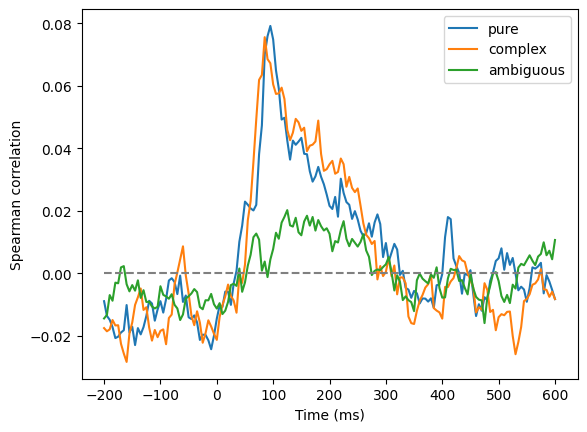

In [12]:
t = np.linspace(-200, 600, len(avg_scores_pure))
plt.plot(t, avg_scores_pure, label="pure")
plt.plot(t, avg_scores_complx, label="complex")
plt.plot(t, avg_scores_ambiguous, label="ambiguous")
plt.plot(t, np.zeros_like(t), linestyle="--", color="gray")
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("Spearman correlation")

In [ ]:
decoder = make_pipeline(
    StandardScaler(),
    Ridge()
)

spearman_scorer = make_scorer(spearmanr, greater_is_better=True)
time_gen = GeneralizingEstimator(decoder, scoring=spearman_scorer, n_jobs=None)
time_gen.fit(X=sub_data[pure], y=freqs[pure])
output = time_gen.score(X=sub_data[pure], y=freqs[pure])

first_elem = lambda tup: tup[0]
first_elem_vectorized = np.vectorize(first_elem)
scores = first_elem_vectorized(output)

100%|██████████████████████████████████████████████| Fitting GeneralizingEstimator : 161/161 [00:04<00:00,   32.70it/s]
 55%|███████████████████████▏                  | Scoring GeneralizingEstimator : 14317/25921 [11:09<08:56,   21.61it/s]

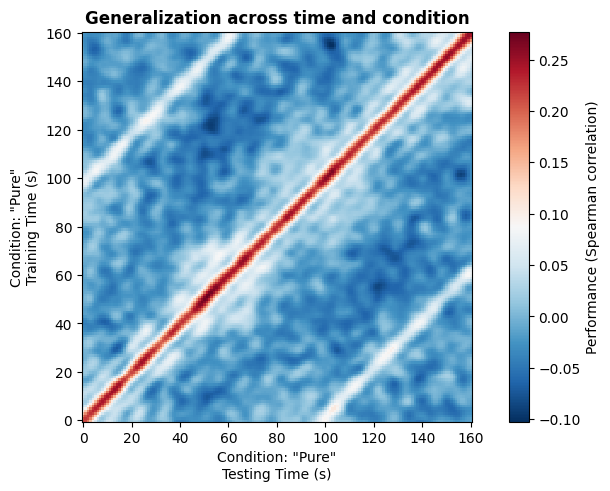

In [15]:
fig, ax = plt.subplots(layout="constrained")
im = ax.matshow(
    avg_scores_gen["ambiguous"],
    cmap="RdBu_r",
    origin="lower"
)
ax.xaxis.set_ticks_position("bottom")
ax.set_xlabel(
    'Condition: "Pure"\nTesting Time (s)',
)
ax.set_ylabel('Condition: "Pure"\nTraining Time (s)')
ax.set_title("Generalization across time and condition", fontweight="bold")
fig.colorbar(im, ax=ax, label="Performance (Spearman correlation)")
plt.show()

In [ ]:
import warnings
warnings.filterwarnings("ignore")

logistic_decoder = make_pipeline(
    StandardScaler(),
    LogisticRegression()
)

features_pc = stim_features[pure | complx,1] == "pure"
input_pc = sub_data[pure | complx]
score_pc, _ = get_perf_timecourse(input_pc, features_pc, logistic_decoder, roc_auc_score)

features_pa = stim_features[pure | ambiguous,1] == "pure"
input_pa = sub_data[pure | ambiguous]
score_pa, _ = get_perf_timecourse(input_pa, features_pa, logistic_decoder, roc_auc_score)

features_ca = stim_features[complx | ambiguous,1] == "partial"
input_ca = sub_data[complx | ambiguous]
score_ca, _ = get_perf_timecourse(input_ca, features_ca, logistic_decoder, roc_auc_score)

In [ ]:
plt.plot(t, score_pc, label="Pure vs. Complex")
plt.plot(t, score_pa, label="Pure vs. Ambiguous")
plt.plot(t, score_ca, label="Complex vs. Ambiguous")
plt.plot(t, 0.5 * np.ones_like(t), linestyle="--", color="gray")
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("ROC AUC Score")
plt.ylim([0,1])

In [ ]:
t0 = 40

clf = make_pipeline(
    StandardScaler(),
    LogisticRegression()
)

kf = StratifiedKFold(5, shuffle=True)
X = input_pc[:,:,t0]
y = features_pc

for train, test in kf.split(X, y):
    X_train = X[train]
    X_test = X[test]
    y_train = y[train]
    y_test = y[test]

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)x
    s = roc_auc_score(y_pred, y_test)
    print("AUC:", s)

Text(0.5, 1.0, 't=35.0ms')

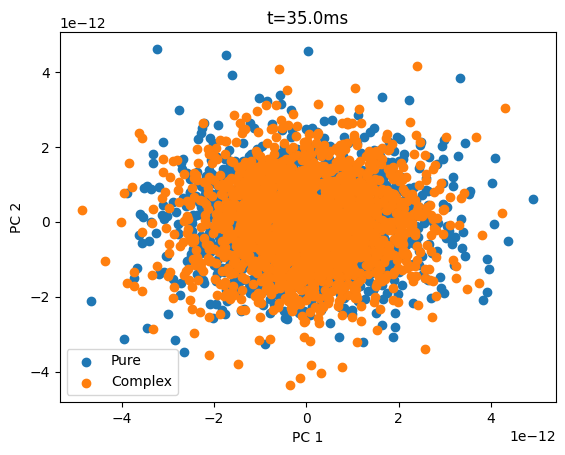

In [40]:
t0 = 47

pca = PCA(n_components=2, svd_solver="full")
transformed = pca.fit_transform(input_pc[:,:,t0])

transformed_pure = transformed[features_pc]
transformed_complx = transformed[~features_pc]

plt.scatter(transformed_pure[:,0], transformed_pure[:,1], label="Pure")
plt.scatter(transformed_complx[:,0], transformed_complx[:,1], label="Complex")
plt.legend()
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title(f"t={t[t0]}ms")

In [18]:
c = 0
loadings = pca.components_[c].copy()
n_top = 3
top_loadings = []

for i in range(n_top):
    max_idx = np.argmax(loadings)
    top_loadings.append((max_idx, loadings[max_idx]))
    loadings[max_idx] = 0
    
top_loadings

[(137, 0.20615029457880427),
 (121, 0.1937262323574115),
 (136, 0.16945149240978483)]

In [38]:
time_gen = GeneralizingEstimator(logistic_decoder, scoring="roc_auc", n_jobs=None)
time_gen.fit(X=input_pc, y=features_pc)
scores_gen_pc = time_gen.score(X=input_pc, y=features_pc)

100%|██████████████████████████████████████████████| Fitting GeneralizingEstimator : 161/161 [00:36<00:00,    4.40it/s]
100%|██████████████████████████████████████████| Scoring GeneralizingEstimator : 25921/25921 [14:39<00:00,   29.47it/s]


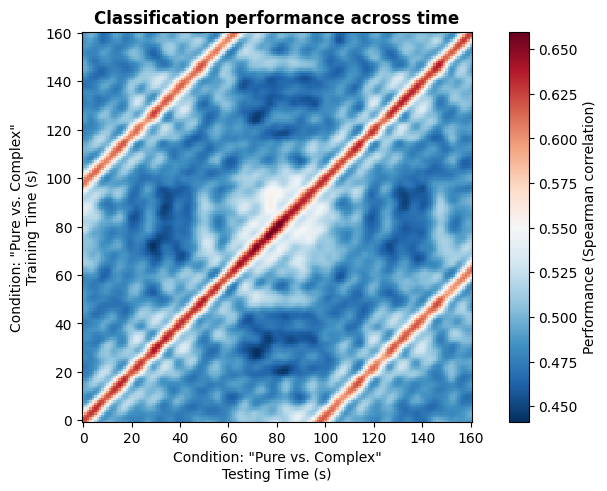

In [39]:
fig, ax = plt.subplots(layout="constrained")
im = ax.matshow(
    scores_gen_pc,
    cmap="RdBu_r",
    origin="lower"
)
ax.xaxis.set_ticks_position("bottom")
ax.set_xlabel(
    'Condition: "Pure vs. Complex"\nTesting Time (s)',
)
ax.set_ylabel('Condition: "Pure vs. Complex"\nTraining Time (s)')
ax.set_title("Classification performance across time", fontweight="bold")
fig.colorbar(im, ax=ax, label="Performance (Spearman correlation)")
plt.show()